In [12]:
from cogpred.utils.naming import make_run_path
import joblib
from cogpred.utils.configuration import get_config
from pathlib import Path

config = get_config()
dir = Path(config["output_dir"]) / "prediction"

conn_dir = config["connectivity_matrices"]

In [13]:
conn_dir

'/homes_unix/jlegrand/data/Memento/output/connectivity'

In [14]:
import joblib
scores = []
names = []
for subdir in dir.iterdir():
    try:
        res = joblib.load(subdir / "test_scores.joblib")
    except FileNotFoundError:
        print(f"{subdir.name} has no available scores")
        continue
    if "experimental-True" not in subdir.name:
        scores.append(res)
        names.append(subdir.name)

k-3_feat-series_experimental-True_atlas-schaefer200 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-04 18:10:38 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 10:30:43 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 11:16:56 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 12:13:19 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:00:50 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:02:36 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:06:46 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:49:20 has no available scores
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_s

In [15]:
import pandas as pd
import seaborn as sns
def shorten(long_name):
    return long_name.split("_")[1].split("-")[1]

df = pd.DataFrame(scores, index=[shorten(name) for name in names], columns=[f"split_{i+1}" for i in range(len(res))])
df

,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8
fc,0.348988,0.487270,0.313220,0.409844,0.364000,0.378382,0.377840,0.373868
volumetry,0.441449,0.432479,0.386072,0.443363,0.432335,0.470547,0.393762,0.344964
dummy,0.288889,0.288889,0.288889,0.288889,0.287485,0.287485,0.288557,0.288557
series,0.339867,0.312338,0.311488,0.335417,0.332579,0.317959,0.336138,0.334709


In [16]:
df.mean(axis=1)

fc           0.381676
volumetry    0.418121
dummy        0.288455
series       0.327562
dtype: float64

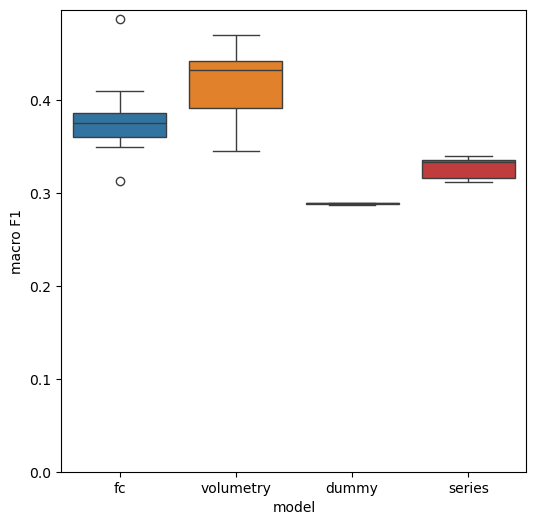

In [17]:
import matplotlib.pyplot as plt
m = df.T.melt(var_name="model", value_name="macro F1")
plt.subplots(figsize=(6, 6))
sns.boxplot(m, y="macro F1", x="model", hue="model")
plt.ylim(0)
plt.show()

In [18]:
import numpy as np
from cogpred.features import make_features
from cogpred.loading import make_test_data, TSFetcher
from neuroginius.atlas import Atlas
ATLAS = "schaefer200"
tspath = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")


In [19]:
atlas = Atlas.from_name(ATLAS)
matrices, metadata = make_test_data(conn_dir, ATLAS, k=3)
dmn_indexer = np.where(np.array(atlas.macro_labels) == "Default", True, False)
fetcher = TSFetcher(tspath)
features = make_features(fetcher, metadata, dmn_indexer)

Dropping 4 subjects because of lacking MMMSE


In [20]:
y_true = metadata.cluster_label.values.astype(int)

In [45]:
exppath = "/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-series_experimental-True_atlas-schaefer200_winsize-48_batchsize-512_niter-1_stamp-2024-07-05-15:58"
exppath = Path(exppath)
cvres = pd.read_csv(exppath / "cv_results.csv", index_col=0)
params = eval(cvres.loc[0, "params"])
expdict = dict()
for k in exppath.name.split("_"):
    exptag = k.split("-")
    expdict[exptag[0]] = exptag[1]

In [50]:
from cogpred.models import WindowNetClassifier, BOLDCNN
from torch import nn

new_net = WindowNetClassifier(
    module=BOLDCNN,
    module__n_channels=sum(dmn_indexer),
    module__window_size=int(expdict["winsize"]),
    criterion=nn.CrossEntropyLoss(),
    **params
)

new_net.initialize()  # This is important!
#new_net.load_params(f_params="/bigdata/jlegrand/data/Memento/output/prediction/k-3_feat-series_atlas-schaefer200/params.pkl")
new_net.load_params(f_params=exppath / "params.pkl")

46 48
256 24


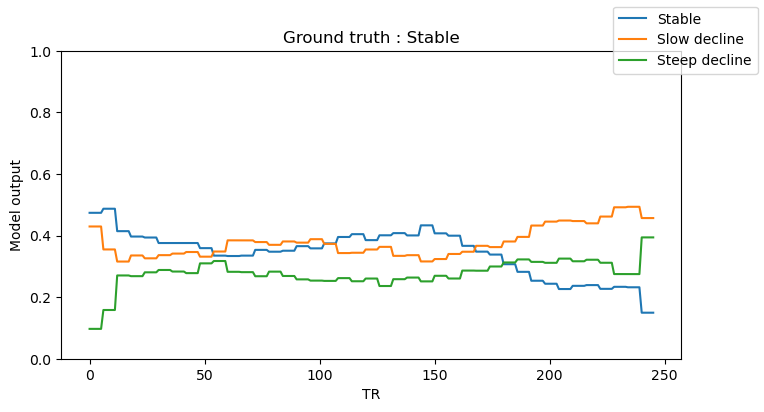

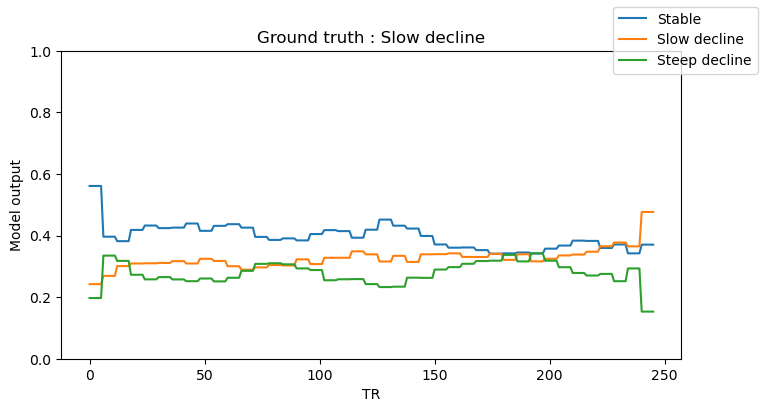

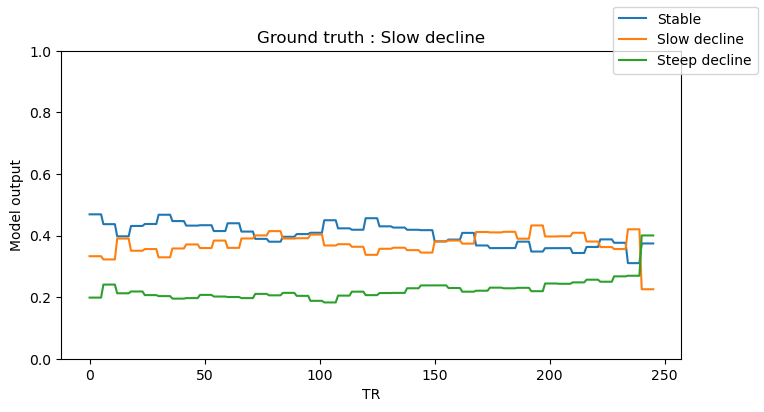

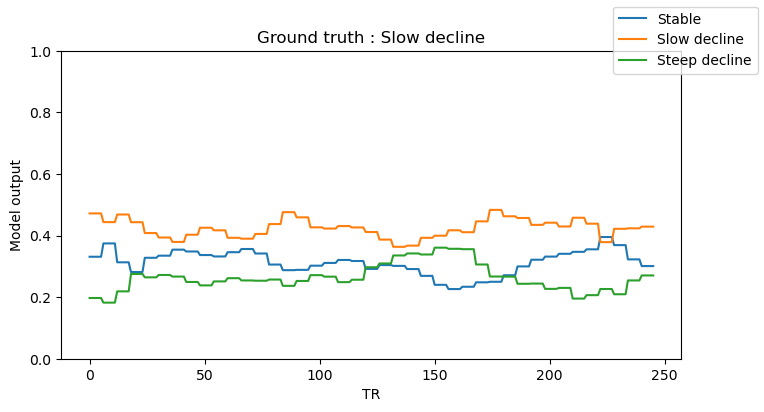

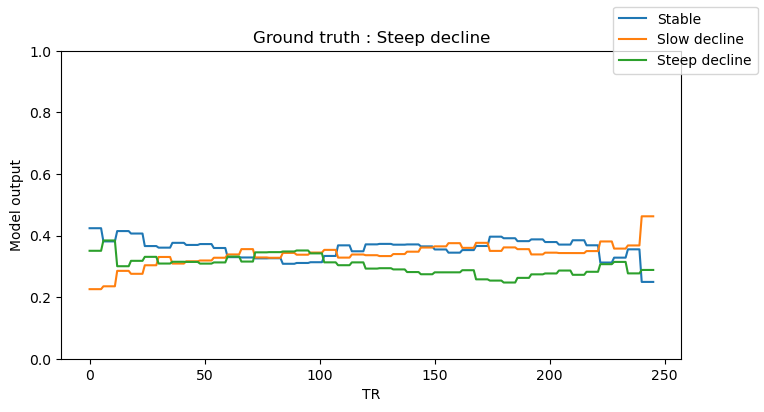

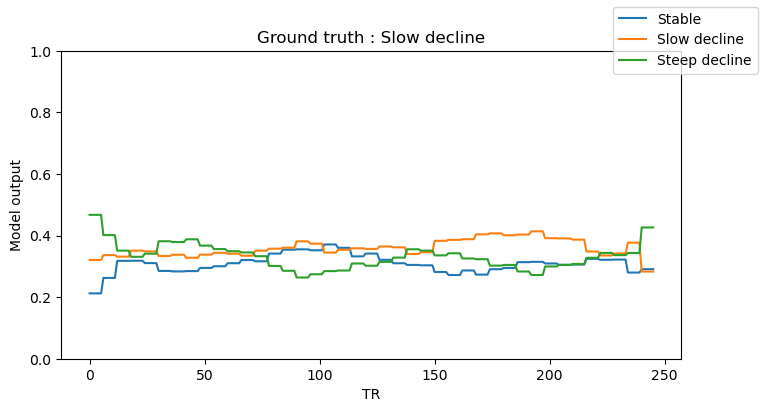

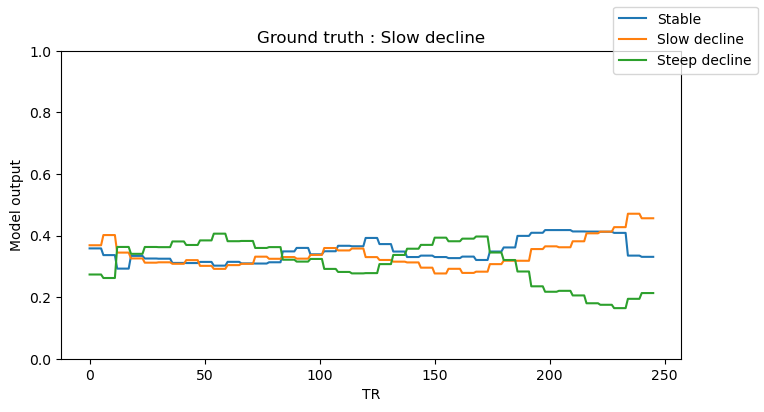

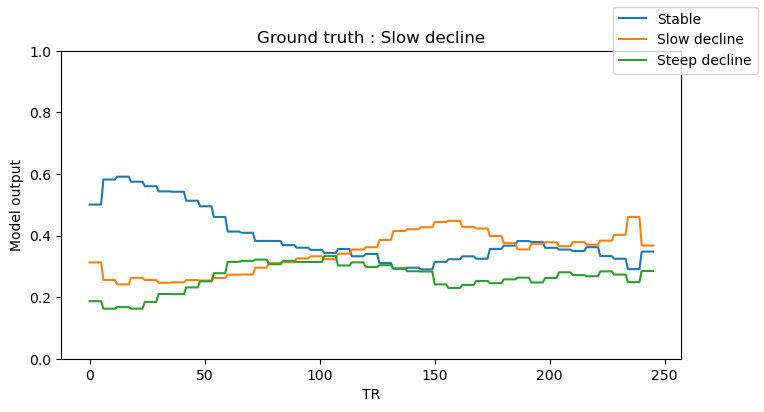

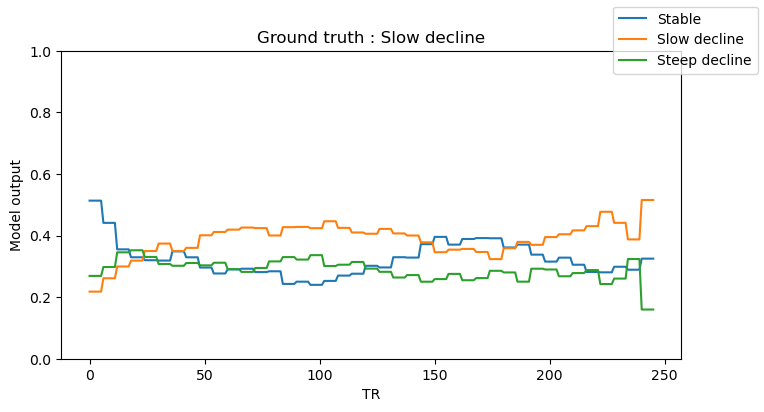

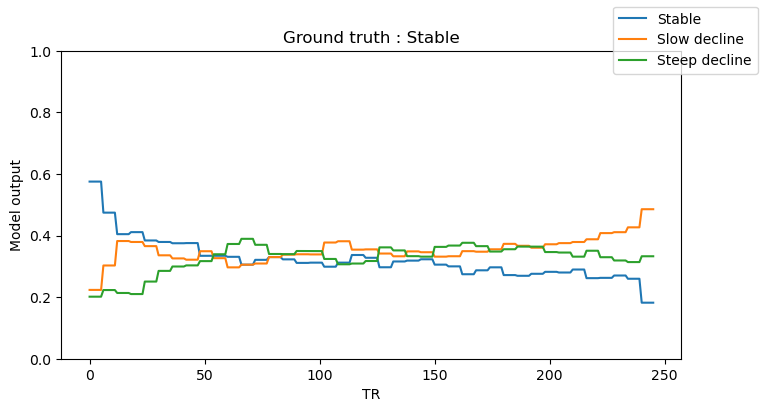

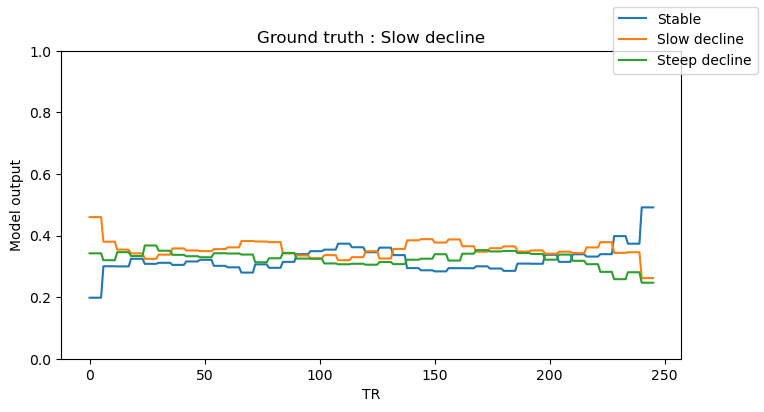

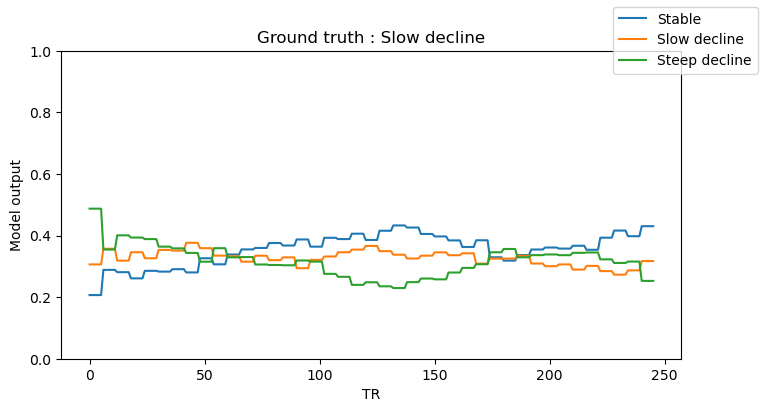

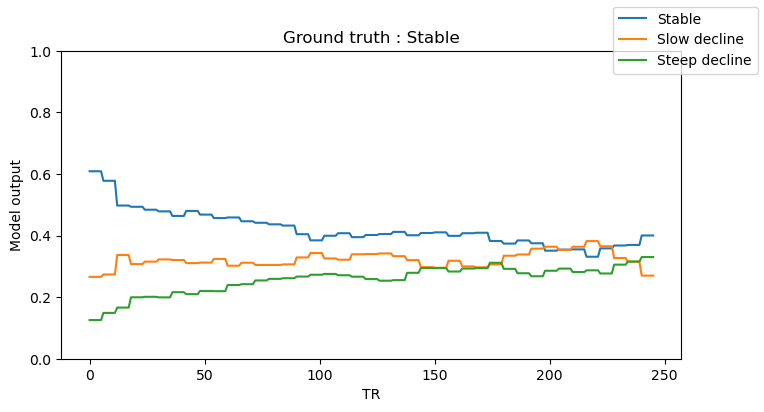

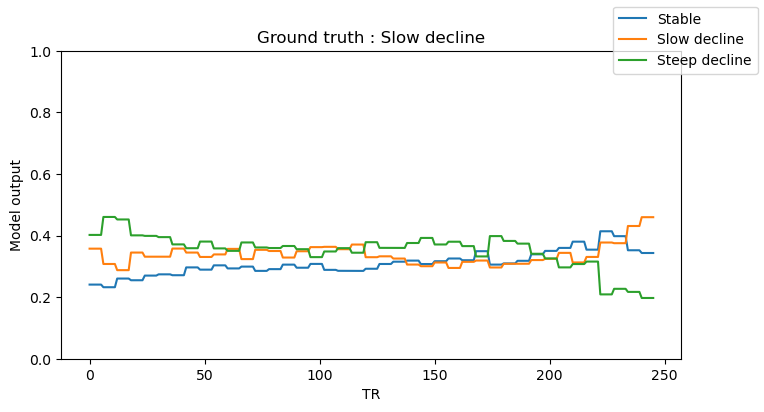

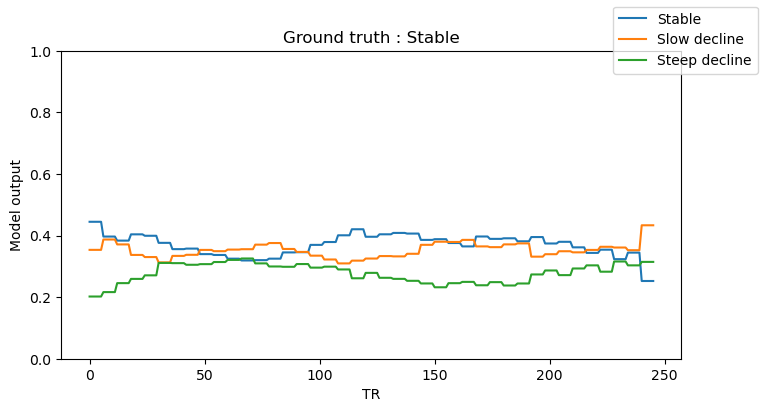

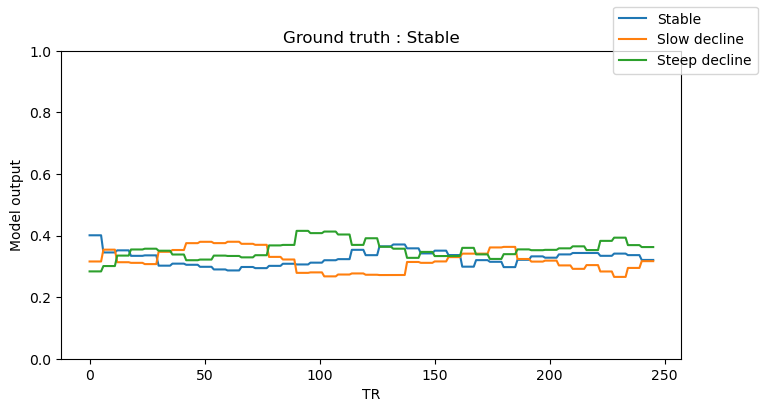

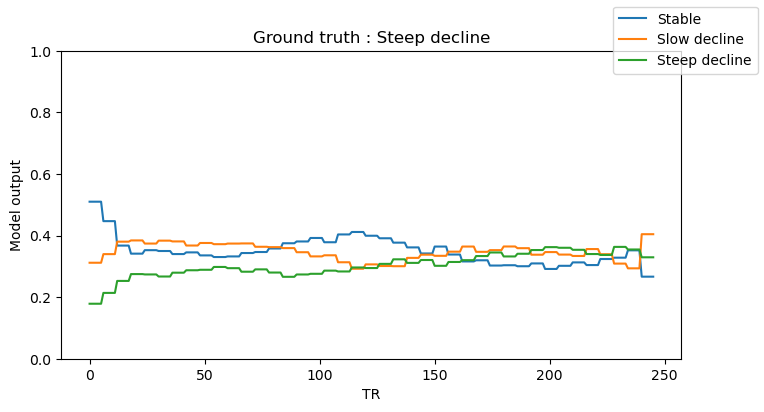

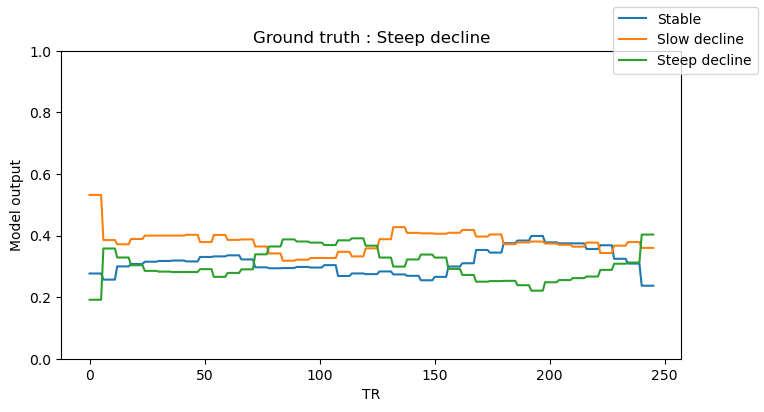

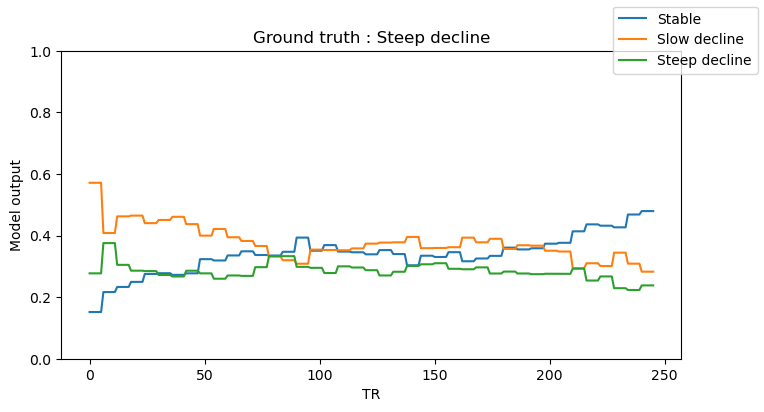

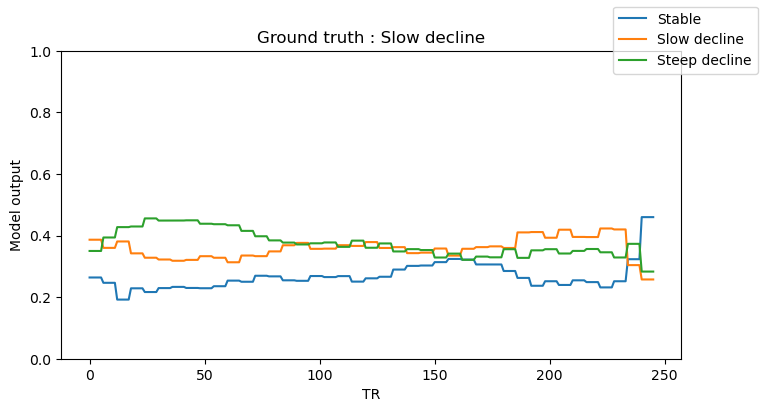

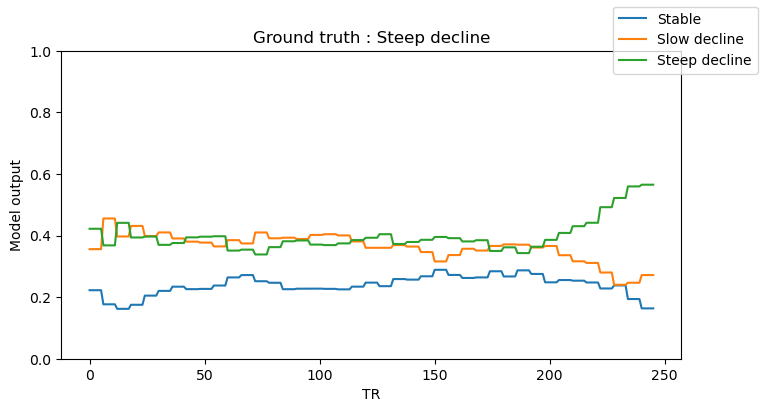

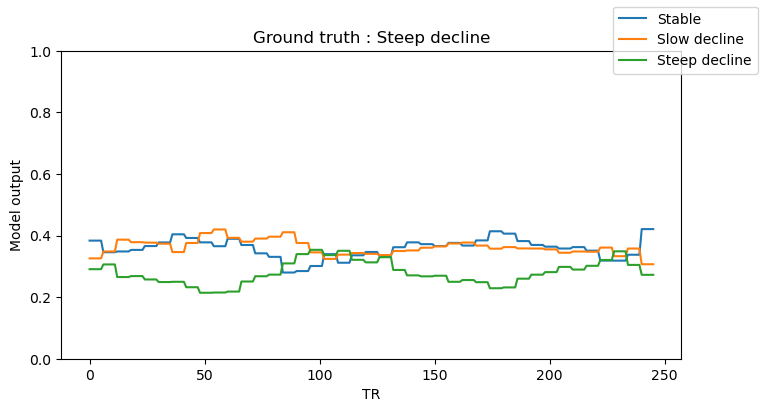

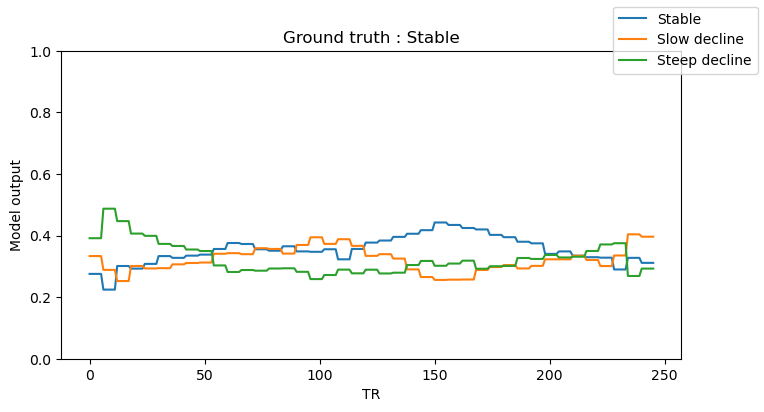

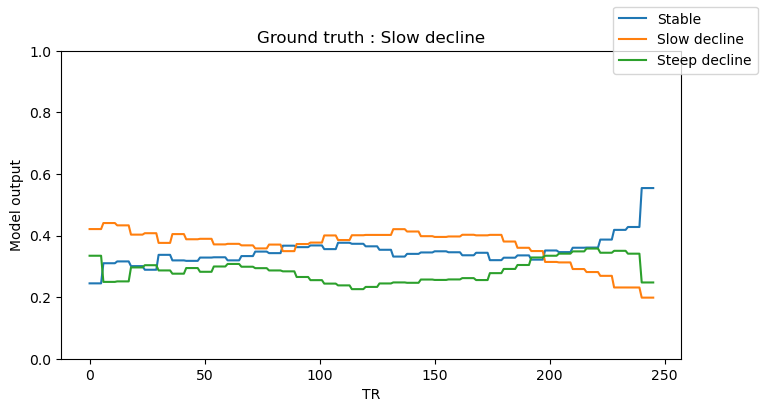

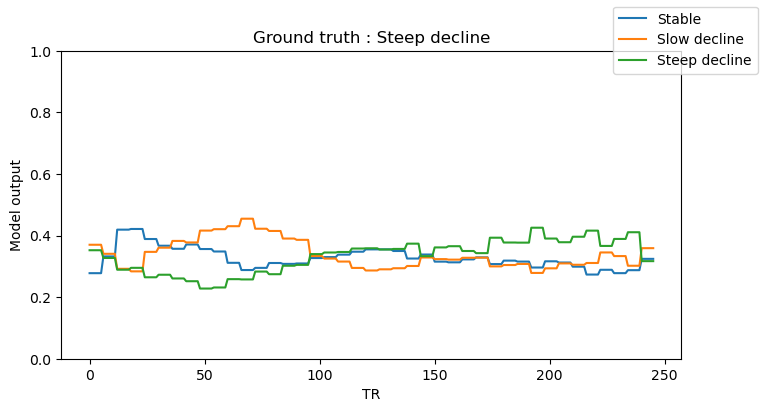

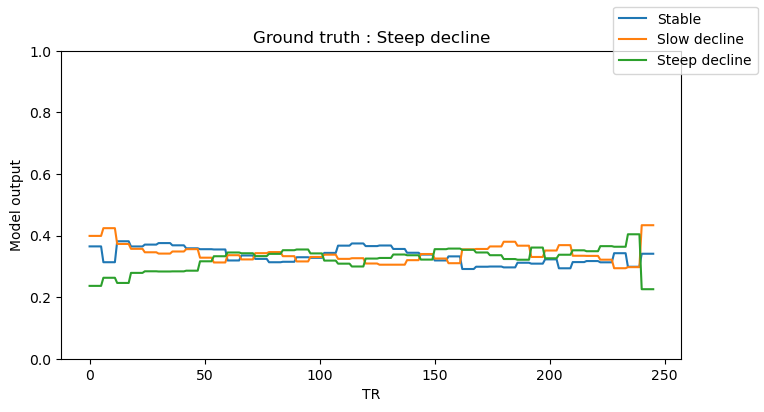

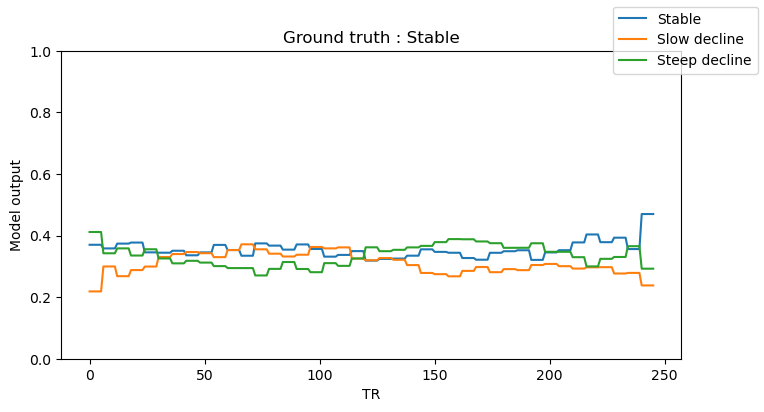

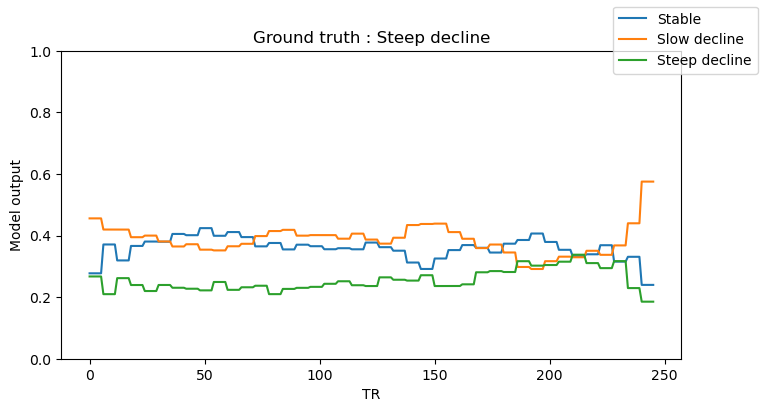

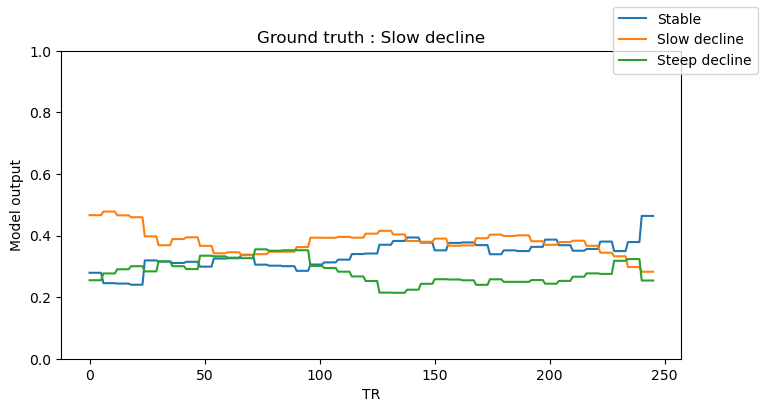

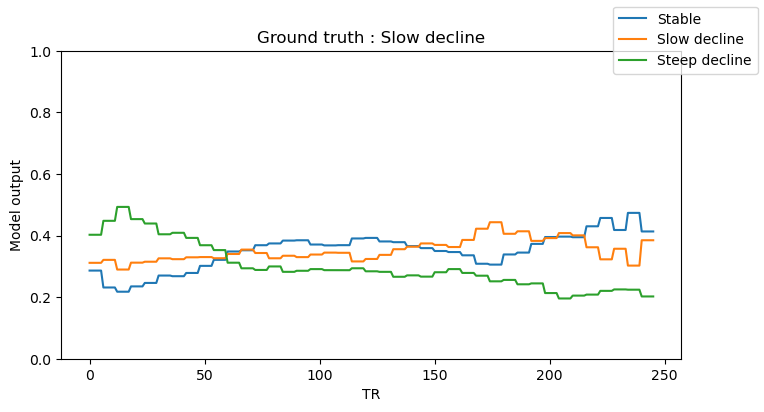

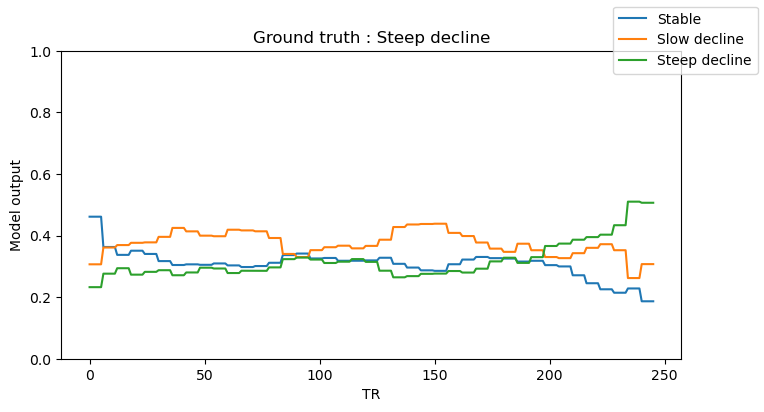

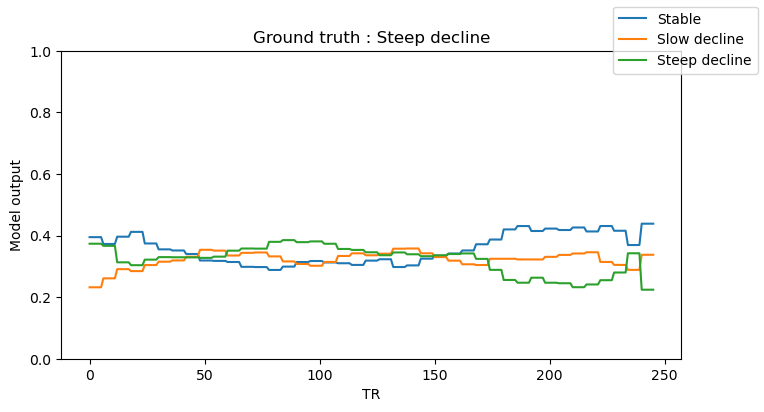

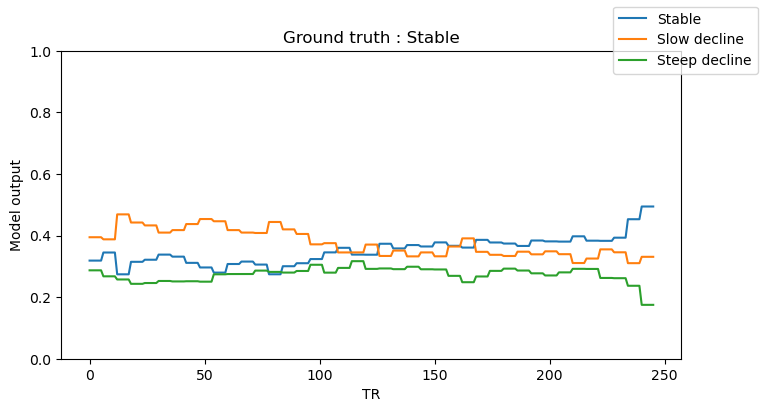

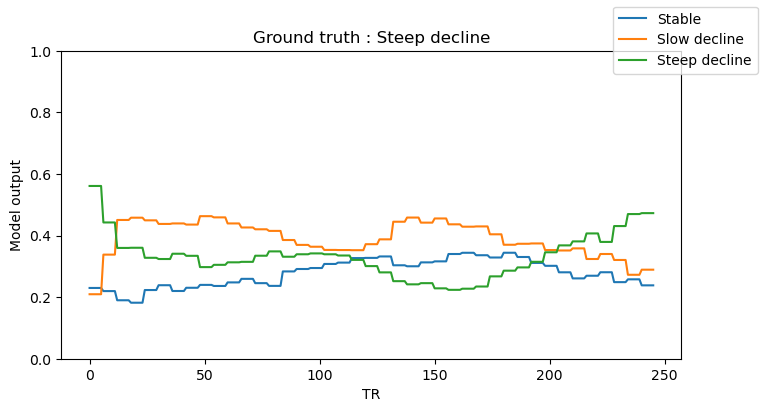

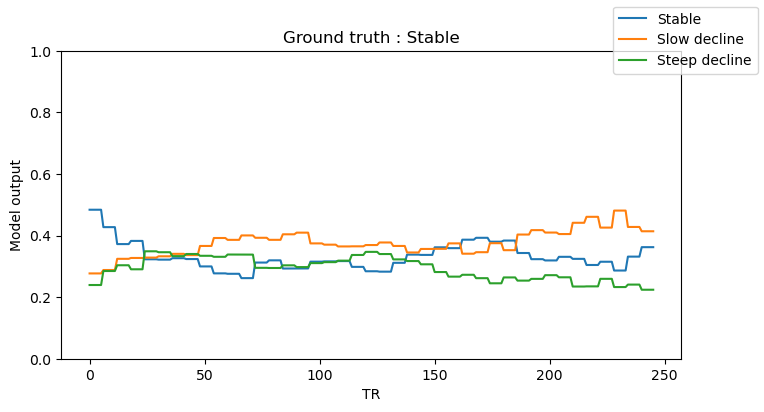

In [52]:
from cogpred.plotting import plot_predictions
label_mapping = ["Stable", "Slow decline", "Steep decline"]

for ts, label in zip(features, y_true):
    ts = ts.T
    ts = ts.reshape(1, *ts.shape)
    p, mask = new_net.sliding_inference(ts, stride=6)
    plot_predictions(p)
    plt.title(f"Ground truth : {label_mapping[label]}")
    plt.show()

    